In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler

In [6]:
with open('/home/docker_current/py_files/MLCLIP_exp/image_feat_array.npy', 'rb') as f:
    image_feat_array = np.load(f)

with open('/home/docker_current/py_files/MLCLIP_exp/text_feat_array.npy', 'rb') as f:
    text_feat_array = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(text_feat_array, image_feat_array, 
                                                        test_size=0.25, random_state=42)

In [16]:
X_train.shape

(1573, 768)

In [53]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t = torch.FloatTensor(X_test) 
y_val_t = torch.FloatTensor(y_test) 

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [85]:
class DumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 768)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DumNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [87]:
max_epochs = 1000
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        if k == 'train':
            exp_lr_scheduler.step()
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. loss: {loss}")
        accuracy[k].append(loss)

    exp_lr_scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1
Loader: train. loss: 0.20658160746097565
Loader: valid. loss: 0.16623610258102417
Epoch: 2
Loader: train. loss: 0.15786606073379517
Loader: valid. loss: 0.12437867373228073
Epoch: 3
Loader: train. loss: 0.1422174870967865
Loader: valid. loss: 0.11381198465824127
Epoch: 4
Loader: train. loss: 0.13282538950443268
Loader: valid. loss: 0.10875844210386276
Epoch: 5
Loader: train. loss: 0.12647294998168945
Loader: valid. loss: 0.10482904314994812
Epoch: 6
Loader: train. loss: 0.12147106230258942
Loader: valid. loss: 0.10154809802770615
Epoch: 7
Loader: train. loss: 0.1172608733177185
Loader: valid. loss: 0.09891092032194138
Epoch: 8
Loader: train. loss: 0.11395981162786484
Loader: valid. loss: 0.09676995873451233
Epoch: 9
Loader: train. loss: 0.11121568828821182
Loader: valid. loss: 0.09507706761360168
Epoch: 10
Loader: train. loss: 0.10876192152500153
Loader: valid. loss: 0.09356330335140228
Epoch: 11
Loader: train. loss: 0.10653875023126602
Loader: valid. loss: 0.09213241189718246

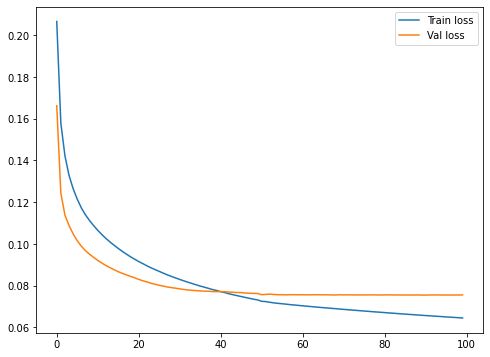

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy['train'][0:100], label='Train loss')
plt.plot(accuracy['valid'][0:100], label='Val loss')
plt.legend()

In [90]:
print(criterion(model(X_val_t.to(device)), y_val_t.to(device)))
print(criterion(model(y_val_t.to(device)), X_val_t.to(device)))

tensor(0.1016, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1252, device='cuda:0', grad_fn=<MseLossBackward0>)


In [132]:
torch.save(model.state_dict(), 'dummy_encoder_mse_loss.pth')

In [103]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

def get_similarity(image_emb, text_emb):
    sim =cos(torch.Tensor(image_emb), 
                        torch.Tensor(text_emb))
    return sim

In [131]:
ind = 0
emb_before_model = X_val_t[ind].unsqueeze(dim=0).cpu()
emb_after_model = model(emb_before_model.to(device)).cpu()
target = y_val_t[ind].unsqueeze(dim=0).cpu()

cos(emb_before_model, target), cos(emb_after_model, target)

(tensor([0.2866]), tensor([0.8440], grad_fn=<DivBackward0>))